# Projeto 2 - Classificador Automático de Sentimento

Você foi contratado por uma empresa parar analisar como os clientes estão reagindo a um determinado produto no Twitter. A empresa deseja que você crie um programa que irá analisar as mensagens disponíveis e classificará como "relevante" ou "irrelevante". Com isso ela deseja que mensagens negativas, que denigrem o nome do produto, ou que mereçam destaque, disparem um foco de atenção da área de marketing.<br /><br />
Como aluno de Ciência dos Dados, você lembrou do Teorema de Bayes, mais especificamente do Classificador Naive-Bayes, que é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser relevante dadas as palavras em seu conteúdo.<br /><br />
Para realizar o MVP (*minimum viable product*) do projeto, você precisa implementar uma versão do classificador que "aprende" o que é relevante com uma base de treinamento e compara a performance dos resultados com uma base de testes.<br /><br />
Após validado, o seu protótipo poderá também capturar e classificar automaticamente as mensagens da plataforma.

## Informações do Projeto

Prazo: 13/Set até às 23:59.<br />
Grupo: 1 ou 2 pessoas.<br /><br />
Entregáveis via GitHub: 
* Arquivo notebook com o código do classificador, seguindo as orientações abaixo.
* Arquivo Excel com as bases de treinamento e teste totalmente classificado.

**NÃO disponibilizar o arquivo com os *access keys/tokens* do Twitter.**


### Check 3: 

Até o dia 06 de Setembro às 23:59, o notebook e o xlsx devem estar no Github com as seguintes evidências: 
    * Conta no twitter criada.
    * Produto escolhido.
    * Arquivo Excel contendo a base de treinamento e teste já classificado.
    

Sugestão de leitura:<br />
http://docs.tweepy.org/en/v3.5.0/index.html<br />
https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/

___

## Preparando o ambiente

Instalando a biblioteca *tweepy* para realizar a conexão com o Twitter:

In [154]:
%%capture
!pip install tweepy

Importando as Bibliotecas que serão utilizadas. Esteja livre para adicionar outras.

In [155]:
import tweepy
import math
import os.path
import pandas as pd
import json
from random import shuffle
import matplotlib.pyplot as plt

___
## Autenticando no  Twitter

Para realizar a captura dos dados é necessário ter uma conta cadastrada no twitter:

* Conta: @vaprigliano1


1. Caso ainda não tenha uma: https://twitter.com/signup
1. Depois é necessário registrar um app para usar a biblioteca: https://apps.twitter.com/
1. Dentro do registro do App, na aba Keys and Access Tokens, anotar os seguintes campos:
    1. Consumer Key (API Key)
    1. Consumer Secret (API Secret)
1. Mais abaixo, gere um Token e anote também:
    1. Access Token
    1. Access Token Secret
    
1. Preencha os valores no arquivo "auth.pass"

**ATENÇÃO**: Nunca divulgue os dados desse arquivo online (GitHub, etc). Ele contém as chaves necessárias para realizar as operações no twitter de forma automática e portanto é equivalente a ser "hackeado". De posse desses dados, pessoas mal intencionadas podem fazer todas as operações manuais (tweetar, seguir, bloquear/desbloquear, listar os seguidores, etc). Para efeito do projeto, esse arquivo não precisa ser entregue!!!

In [156]:
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter:

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Coletando Dados

Agora vamos coletar os dados. Tenha em mente que dependendo do produto escolhido, não haverá uma quantidade significativa de mensagens, ou ainda poder haver muitos retweets.<br /><br /> 
Configurando:

In [157]:
#Produto escolhido:
produto = 'Nubank'

#Quantidade mínima de mensagens capturadas:
n = 500
#Quantidade mínima de mensagens para a base de treinamento:
t = 300

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [158]:
#Cria um objeto para a captura
api = tweepy.API(auth)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang).items():    
    msgs.append(msg.text.lower())
    i += 1
    if i > n:
        break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

Salvando os dados em uma planilha Excel:

In [159]:
#Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #divide o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fecha o arquivo
    writer.save()

___
## Classificando as Mensagens

Agora você deve abrir o arquivo Excel com as mensagens capturadas e classificar na Coluna B se a mensagem é relevante ou não.<br /> 
Não se esqueça de colocar um nome para a coluna na célula **B1**.<br /><br />
Fazer o mesmo na planilha de Controle.

___
## Montando o Classificador Naive-Bayes

Com a base de treinamento montada, comece a desenvolver o classificador. Escreva o seu código abaixo:

Opcionalmente: 
* Limpar as mensagens removendo os caracteres: enter, :, ", ', (, ), etc. Não remover emojis.<br />
* Corrigir separação de espaços entre palavras e/ou emojis.
* Propor outras limpezas/transformações que não afetem a qualidade da informação.



In [160]:
#limpando os comentarios

limpa = [ ',', '"', '(', ')','.',',']
dados = pd.read_excel('Nubank.xlsx',sep=',')

for palavra in limpa: dados['Treinamento'] = dados['Treinamento'].str.replace(palavra, ' ')  #remove as palavras da lista "limpa"

In [161]:
d = (dados['Relevante'].value_counts(sort=False, normalize=True)*100).round(decimals=1)  #frequencia de relevantes e não relevantes

pr = d['sim'] #probabilidade de ser relevante
pn = d['não'] #probabilidade de nao ser relevante

treinamento = dados.Treinamento.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0) #frequencia absoluta de cada palavra
tr = dados.Treinamento[dados.Relevante == 'sim'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0) #frequencia absoluta de cada palavra nos relevante
tn = dados.Treinamento[dados.Relevante == 'não'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0) #frequencia absoluta de cada palavra nos nao relevantes
nr = tr[0]  #numero total absoluto de palavras nos relevantes
nn = tn[0]  #numero total absoluto de palavras nos nAO relevantes
n = len(treinamento) #numero total de palavras (sem contar repeticoes) (possible words)

nr = nr.item()
nn = nn.item()

nr = int(nr)
nn = int(nn)

freqr = pd.DataFrame(tr)
freqn = pd.DataFrame(tn)

lf = []  
ln = [] 


for i in range(len(freqr)):
    x = (((freqr.iat[i,0])+1)/(nr+n))*pr
    lf.append(x)
    

for i in range(len(freqn)):
    x = (((freqn.iat[i,0])+1)/(nn+n))*pn
    ln.append(x)

lr = freqr.index.tolist() 
l = freqn.index.tolist() 

dr = {}
dn = {}

for i in range(len(freqr)):
    dr[lr[i]] = lf[i]
    
for i in range(len(freqn)):
    dn[l[i]] = ln[i]

In [162]:
#testando o código

teste = pd.read_excel('Nubank.xlsx',sep=',', sheetname="Teste")
t1 = 0
for index, row in teste.iterrows():
    y1 = 1
    y2 = 1

    p = row['Treinamento'] #proprio tweet
    l = p.split() #lista de palavras de um tweet
    for i in l:
        if i in dr:
            y1 *= (dr[i])
        if i in dn:
            y2 *= (dn[i])
    if y1>y2:
        teste.set_value(index, 'Relevante', 'sim')
        ui = t1+1        
        
    else:
        teste.set_value(index, 'Relevante', 'não')
    
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('resultado.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
teste.to_excel(writer, sheet_name='Testado')

# Close the Pandas Excel writer and output the Excel file.
writer.save()


___
## Verificando a performance

Agora você deve testar o seu Classificador com a base de Testes.<br /><br /> 

Você deve extrair as seguintes medidas:
* Porcentagem de positivos falsos (marcados como relevante mas não são relevantes)
* Porcentagem de positivos verdadeiros (marcado como relevante e são relevantes)
* Porcentagem de negativos verdadeiros (marcado como não relevante e não são relevantes)
* Porcentagem de negativos falsos (marcado como não relevante e são relevantes)

Opcionalmente:
* Criar categorias intermediárias de relevância baseado na diferença de probabilidades. Exemplo: muito relevante, relevante, neutro, irrelevante e muito irrelevante.

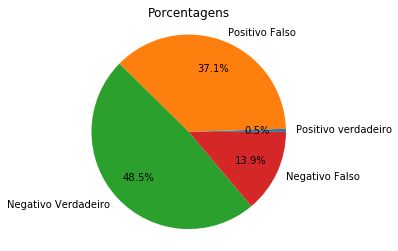

In [163]:
pv = 0
pf = 0 
nv = 0
nf = 0

dados2 = pd.read_excel('Nubank.xlsx',sep=',', sheetname="Teste")
n = len(teste) #usando como amostra a quantidade de valores na planilha "Teste"

for i, row in teste.iterrows():
        a1 = row["Relevante"] #pega os valores de cada linha da coluna "relevante"
        a2 = dados2.Relevante[i]

        if a1 == "sim" and a2 == "sim":
            pv = pv +1
       
        if  a1 == "não" and a2 == "sim":
            pf = pf + 1
    
        if a1 == "não" and a2 == "não":
            nv = nv + 1
         
        if a1 == "sim" and a2 == "não":
            nf = nf + 1
                        
vf1 = ((pv/n)*100) 
vf2 = ((pf/n)*100)
vf3 = ((nv/n)*100)
vf4 = ((nf/n)*100)


import matplotlib.pyplot as plt


plt.pie(lv, labels=['Positivo verdadeiro','Positivo Falso','Negativo Verdadeiro','Negativo Falso'],pctdistance=0.7, labeldistance=1.1, center=(0, 0), autopct='%1.1f%%')               
plt.axis('equal')
plt.title("Porcentagens")
plt.show()


     
        

___
## Concluindo

Escreva aqui a sua conclusão.<br /> 
Faça um comparativo qualitativo sobre as medidas obtidas.<br />
Explique como são tratadas as mensagens com dupla negação e sarcasmo.<br />
Proponha um plano de expansão. Por que eles devem continuar financiando o seu projeto?<br />

Opcionalmente: 
* Discorrer por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador, aplicado a novos tweets.
* Propor diferentes cenários de uso para o classificador Naive-Bayes. Cenários sem intersecção com este projeto.
* Sugerir e explicar melhorias reais no classificador com indicações concretas de como implementar (não é preciso codificar, mas indicar como fazer e material de pesquisa sobre o assunto).


    A partir de toda a análise feita nas linhas acima pode-se fazer uma conclusão final sobre a relevância dos tweets feitos sobre o produto escolhido, no caso o Nubank.
    
    Para início dessa conclusao deve-se fazer uma comparação dos números finais, ou seja a real relevância de cada tweet, nomeados de positivos verdadeiros ou falsos e o mesmo para negativos, verdadeiros ou falsos. Como visto no gráfico acima, a porcentagem de classificação para positivos verdadeiros é baixíssima o que mostra uma inconsistência do programa, além do que há um valor significativo para positivos falsos, ou seja marcados equivocadamente como relevantes, representado 37,1% dos valores. Por outro lado o programa se mostrou eficiente na observação de negativos, pois os comentários marcados como não relevantes que realmente nao são, se mostram como 48,5% da classificação, mesmo que negativos falsos, apresentem 13,9% da classificação, e seja para casos em que se classificou de uma maneira e a filtragem teve que corrigi-los para sua real relevância. Pode-se afirmar que a porcentagem de "acertos" na classificação foi baixa, 49% do total, ou seja aquilo que foi classificado se manteve na mesma classificação após filtragem do sistema em 49% dos casos, isso mostra um certa ineficiência do sistema por um lado, mas também pode ser positivo se observar apenas os valores de classificação para irrelevantes, que apresentam quase metade de todos os valores. 
    
    A seguir deve-se destacar o método de funcionamento do programa. Isso porque ele se baseia em uma análise de palavra em palavra até que se complete cada um dos tweets, para que então se classifique de acordo com sua relevância. Para que se observe um tweet com dupla negação ou sarcasmo, ou seja efeitos de sentido, seria necessário analisar a frase como um todo, o que não é possível por conta da maneira de leitura do sistema. Dessa forma mensagens que apresentem algum desses dois tipos de efeito, dupla negação e/ou sarcasmo, são classificados como normais em relevantes ou irrelevantes mesmo que alguns daqueles dois mude seu real significado. Infelizmente isso se aponta como uma inconsistência do sistema.
    
    Por fim é válido afirmar que apesar de o "acerto" não ser tão alto como se esperava, o projeto tende a melhorar, ou seja os comentários verdadeiros devem aumentar em porcentagem se o projeto continuar sendo desenvolvido. Isso por conta de melhorias no código de filtragem, maior atenção na classificação inicial e por ser um projeto relevante como um todo, afinal a partir do uso deste sistema é possível saber como são tratados os assuntos no Twitter (nesse caso), ou seja mais sérios e formais, porcentagem de comentários relevantes reais maior, ou de maneira mais informal e de âmbito menos relevantes, porcentagem de comentários irrelevantes maior. Dessa forma defende-se que o projeto possa ser levado adiante e continua sendo financiado para posteriores análises mais complexas e de maior eficiência.